# pm2.5 training notebook

In [1]:
import json
import datetime as dt
import pytz
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection
from scipy import stats

from bs4 import BeautifulSoup

## Functions that get data from server to us

In [2]:
def get_data_by_pos(pos):
    r = requests.get(f'http://140.116.82.93:6800/campus/display/{ pos }')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

In [3]:
def get_all_data():
    r = requests.get(f'http://140.116.82.93:6800/training')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

## 特定一個 position 的 Linear Regression

暫定的做法是：將每一小時的資料做平均，然後將下一小時的 pm2.5 平均當作想要預測的 y。如果下一小時的 pm2.5 平均無法取得(資料缺失)，則將該 row 捨棄。拿來訓練的 columns 目前有 'month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity'。

### Load data


In [4]:
pos = 3
data3 = get_data_by_pos(pos)

In [5]:
df3 = pd.DataFrame(data3)

In [6]:
df3.head()

,date,humidity,pm10,pm100,pm25,temp
0,2019-05-11 09:28:17+08:00,62,50,94,78,28
1,2019-05-11 09:43:14+08:00,61,36,71,60,29
2,2019-05-11 09:58:13+08:00,59,39,75,63,29
3,2019-05-11 10:13:10+08:00,59,41,78,66,29
4,2019-05-11 10:28:07+08:00,59,33,67,52,30


### Data preprocessing

In [7]:
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]

In [8]:
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

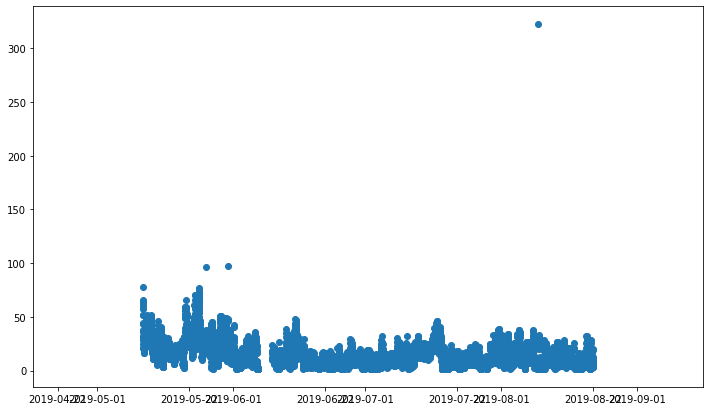

In [9]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df3['date'], df3['pm2.5'])

In [10]:
# Data cleaning
# want_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']
# df3 = df3[(np.abs(stats.zscore(df3.loc[:, want_cols])) < 7).all(axis=1)]
df3 = df3.loc[ df3['pm2.5'] <= 120 ]
df3 = df3.loc[ df3['humidity'] <= 100 ]

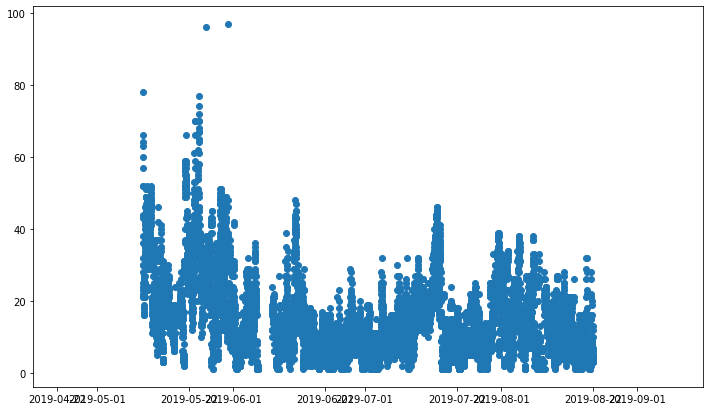

In [11]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df3['date'], df3['pm2.5'])

In [12]:
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)

In [13]:
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]

In [14]:
df3.head()

,month,day,weekday,hour,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,11,5,9,9.466667,50,78,94,28,62
1,5,11,5,9,9.716667,36,60,71,29,61
2,5,11,5,9,9.966667,39,63,75,29,59
3,5,11,5,10,10.216667,41,66,78,29,59
4,5,11,5,10,10.466667,33,52,67,30,59


In [15]:
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()

In [16]:
df3mean.head(10)

weekday  hour_minute      pm1.0  pm2.5  pm10.0       temp  \
month day hour                                                              
5     11  9         5.0     9.716667  41.666667  67.00   80.00  28.666667   
          10        5.0    10.591667  37.250000  59.75   72.75  29.750000   
          11        5.0    11.575000  28.500000  44.25   56.25  31.750000   
          12        5.0    12.575000  21.500000  32.00   37.00  35.000000   
          13        5.0    13.575000  18.500000  23.75   24.75  37.250000   
          14        5.0    14.575000  17.000000  22.50   23.50  37.750000   
          15        5.0    15.575000  19.000000  25.25   26.25  36.000000   
          16        5.0    16.575000  19.750000  26.50   29.00  32.500000   
          17        5.0    17.575000  14.250000  20.00   20.75  29.000000   
          18        5.0    18.575000  12.250000  17.25   18.75  27.000000   

                 humidity  
month day hour             
5     11  9     60.666667  
          10    58.000000  
          11    51.500000  
          12    43.500000  
          13    37.750000  
          14    36.750000  
          15    41.000000  
          16    49.500000  
          17    56.500000  
          18    61.500000

In [17]:
# Create hourly time
hourly = pd.period_range(start='2019-05-11', end='2019-08-30', freq='H')
hourlydf = pd.DataFrame(hourly, columns=['time'])

In [18]:
# Split time infomation
hourlydf['month'] = hourlydf['time'].apply(lambda x: x.month)
hourlydf['day'] = hourlydf['time'].apply(lambda x: x.day)
hourlydf['hour'] = hourlydf['time'].apply(lambda x: x.hour)
# Set index
hourlydf.set_index(['month', 'day', 'hour'], inplace=True)

In [19]:
# Concat !!!!!!!!
dfconcat = pd.concat([hourlydf, df3mean], axis=1, sort=False)
# Reset index
dfconcat.reset_index(inplace=True)

In [20]:
dfconcat.head()

,month,day,hour,time,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,11,0,2019-05-11 00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,11,1,2019-05-11 01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,11,2,2019-05-11 02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,11,3,2019-05-11 03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,11,4,2019-05-11 04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)

In [22]:
dfconcat.head()

,month,day,hour,time,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,11,0,2019-05-10 23:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,11,1,2019-05-11 00:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,11,2,2019-05-11 01:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,11,3,2019-05-11 02:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,11,4,2019-05-11 03:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


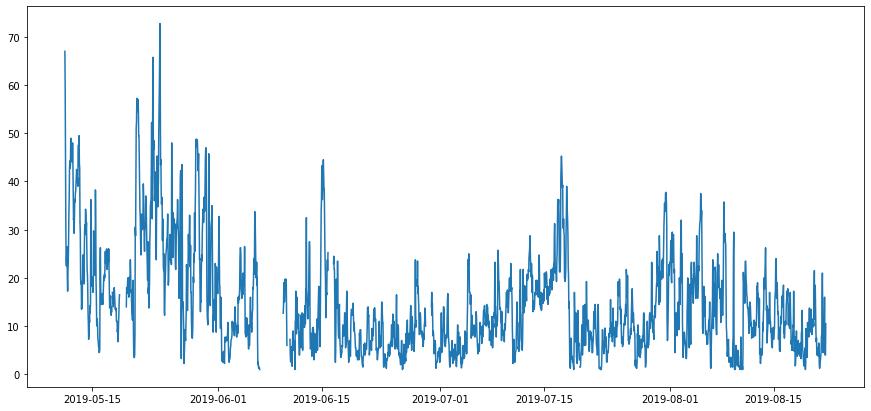

In [23]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(15, 7))
plt.plot(dfconcat['time'], dfconcat['pm2.5'])

In [24]:
# Shift columns
dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-1)
dfconcat[['time_shift']] = dfconcat[['time']].shift(-1)

In [25]:
dfconcat.head()

,month,day,hour,time,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,pm2.5_shift,time_shift
0,5,11,0,2019-05-10 23:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-11 00:54:00+08:00
1,5,11,1,2019-05-11 00:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-11 01:54:00+08:00
2,5,11,2,2019-05-11 01:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-11 02:54:00+08:00
3,5,11,3,2019-05-11 02:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-11 03:54:00+08:00
4,5,11,4,2019-05-11 03:54:00+08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-11 04:54:00+08:00


In [26]:
dfconcat.isna().sum()

month            0
day              0
hour             0
time             0
weekday        344
hour_minute    344
pm1.0          344
pm2.5          344
pm10.0         344
temp           344
humidity       344
pm2.5_shift    344
time_shift       1
dtype: int64

In [27]:
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)

In [28]:
dfconcat.isna().sum()

month          0
day            0
hour           0
time           0
weekday        0
hour_minute    0
pm1.0          0
pm2.5          0
pm10.0         0
temp           0
humidity       0
pm2.5_shift    0
time_shift     0
dtype: int64

### Normalization

$z = \frac{x- \mu}{\sigma}$


In [29]:
# Save mean and std
want_cols = ['pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'pm2.5_shift']
mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all

### Divid training set and test set

In [30]:
four_fifth_len = len(dfconcat)*0.8
four_fifth_len = int(four_fifth_len)

In [31]:
train_df = dfconcat[:four_fifth_len]
test_df = dfconcat[four_fifth_len:]

### Select features

In [32]:
# 'month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'speed'
X = train_df[['temp', 'humidity']]
y = train_df[['pm2.5_shift']]

In [33]:
test_X = test_df[['temp', 'humidity']]
test_y = test_df[['pm2.5_shift']]

### Fit the model

using `sklearn.linear_model.LinearRegression`

In [34]:
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [35]:
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])

Coefficient for       temp:	-0.7101646628832936
Coefficient for   humidity:	-0.7511207446678049
Intercept: 			 0.03071723915819108


In [36]:
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)

In [37]:
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

m = mean_all['pm2.5']
s = std_all['pm2.5']

test_df_ori = test_df['pm2.5'] * s + m

In [38]:
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Train MSE:	 112.411224,	 RMSE: 10.602416 (μg/m^3),	 MAPE:	 108.952644 %
Test MSE:	 61.141694,	 RMSE: 7.819315 (μg/m^3),	 MAPE:	 122.417739 %


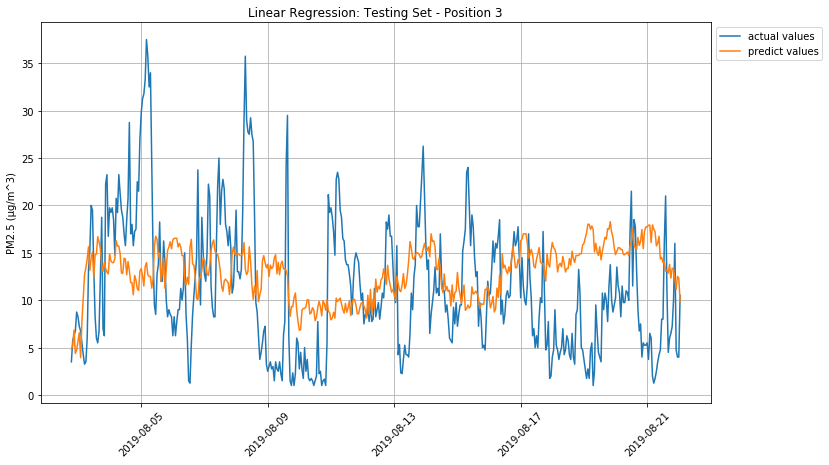

In [39]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

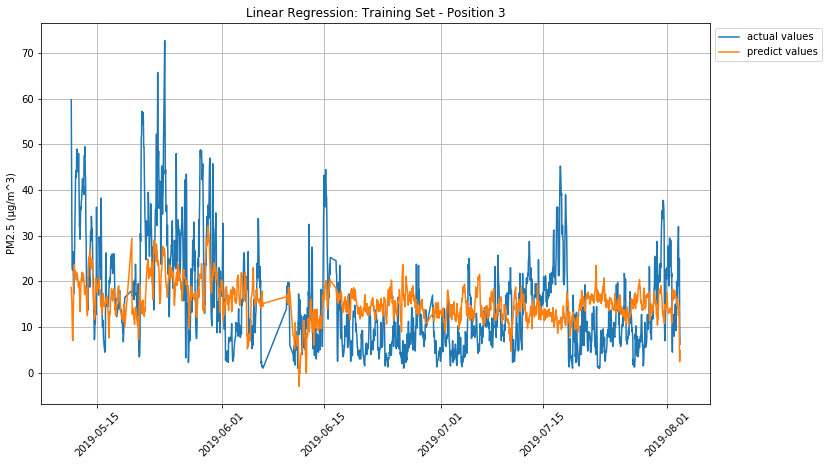

In [40]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(train_df['time_shift'], y_ori, label='actual values')
plt.plot(train_df['time_shift'], predict_train_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Training Set - Position %d' % pos)
plt.grid()
plt.show()

### Feature Selection via Ridge Regression

~~Our test error is worse than our training error. Therefore, our next job is to improve this.~~

Next, we improve mean squared error. 

We use the class `sklearn.linear_model.Ridge`. We will throw all features in, let ridge regression do selection, and see how our own feature sets compare. Notice we have an additional hyperparameter,  𝛼 . This controls how heavy the penalty is for larger weights.

To perform hyperparameter tuning we can use a technique called **cross validation**. We take our test set, randomly divide into  𝑘  training and testing sets. Differnent samples will be randomly placed in each set, each with their own variance. We then average the results over the folds to estimate how well we will do on unseen test data. After splitting the data into  𝑘  folds (10 is a usual choice for  𝑘 ), we will try out different hyperparameter values and select the best one. Much of this process is already wrapped in `sklearn.model_selection.cross_val_score` for us. We just need to define a scoring function.


In [41]:
# Define a scoring function
def scorer(model, X, y):
    preds = model.predict(X)
    return metrics.mean_squared_error(y, preds)

In [42]:
# Define a range of values for alpha to search over.
alphas = np.linspace(start=0, stop=100, num=11)

mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, X, y, cv=10, scoring=scorer)
    mses.append(mse.mean())

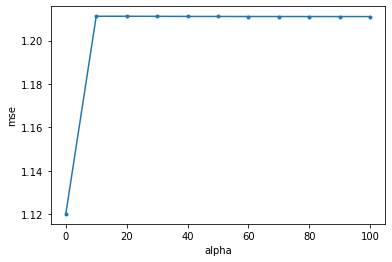

In [43]:
plt.plot(alphas, mses, marker='.')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

In [44]:
best_alpha = alphas[np.argmin(mses)]
best_alpha

0.0

In [45]:
# Use `best_alpha` to fit the model
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(X, y)

Ridge(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [46]:
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], ridge.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])

Coefficient for       temp:	-0.7101646628832963
Coefficient for   humidity:	-0.7511207446678073
Intercept: 			 0.03071723915819108


In [47]:
# Calculate mean squared error for training set & test set
predict_train_y = ridge.predict(X)
predict_y = ridge.predict(test_X)

In [48]:
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

m = mean_all['pm2.5']
s = std_all['pm2.5']

test_df_ori = test_df['pm2.5'] * s + m

In [49]:
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Train MSE:	 112.411224,	 RMSE: 10.602416 (μg/m^3),	 MAPE:	 108.952644 %
Test MSE:	 61.141694,	 RMSE: 7.819315 (μg/m^3),	 MAPE:	 122.417739 %


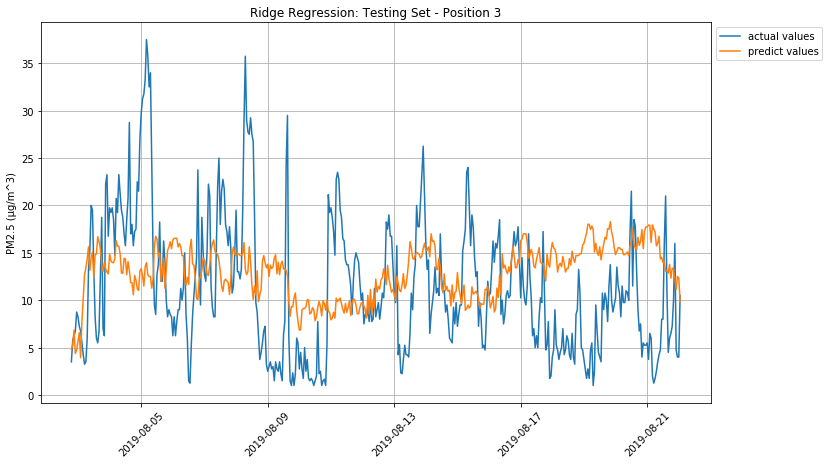

In [50]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Ridge Regression: Testing Set - Position %d' % pos)
plt.grid()
plt.show()

### Add wind speed

In [51]:
station = str(467410)

def crawler(month, date):
    # create url
    
    mon = ''
    if month < 10:
        mon = '0' + str(month)
    else:
        mon = str(month)
    
    day = ''
    if date < 10:
        day = '0' + str(date)
    else:
        day = str(date)
    datepicker = '2019-' + mon + '-' + day
    
    # url: https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=467410&stname=&datepicker=2019-08-07
    url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=' + station + '&stname=&datepicker=' + datepicker
    # print(url)
    
    # request
    response = requests.get(url)
    # print(response.text)
    
    # html parsing
    soup = BeautifulSoup(response.text, features="html.parser")
    
#    title = ['WS', 'WD']
    
    # get the daily data
    body = soup.tbody
    trs = body.find_all('tr')
    trs = trs[3:]
    
    winddata = []
    hour = 0
    # extract wind speed and wind direction
    for tds in trs:
        sd = {}
        td = tds.find_all('td')
#        print(td[0].string)
#        print(td[6].string)
#        print(td[7].string)
#        print('---')
#        if td[7].string == "V\xa0":
#            td[7].string = "0"
        sd['month'] = month
        sd['day'] = date
        sd['hour'] = hour
        sd['speed'] = float(td[6].string)
#        sd.append(int(td[7].string))
        winddata.append(sd)
        hour += 1
    
    # turn the list to dataframe
    #df = pd.DataFrame(data=winddata, columns=title)
    
    return winddata

In [52]:
wind_data = []
for month in [5, 6, 7, 8]:
    if month == 5:
        r = range(11, 32)
    elif month == 6:
        r = range(1, 31)
    elif month == 7:
        r = range(1, 32)
    elif month == 8:
        r = range(1, 18)
    for day in r:
        tmp = crawler(month, day)
        wind_data = wind_data + tmp

In [53]:
wind = pd.DataFrame(wind_data)

In [54]:
wind.set_index(['month', 'day', 'hour'], inplace=True)

In [55]:
# Load data
pos = 3
data3 = get_data_by_pos(3)
df3 = pd.DataFrame(data3)
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Data cleaning
df3 = df3.loc[ df3['pm2.5'] <= 120 ]
df3 = df3.loc[ df3['humidity'] <= 100 ]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()

In [56]:
# Concat !!!!!!!!
dfconcat = pd.concat([df3mean, wind], axis=1, sort=False)

Coefficient for       temp:	-0.6330201284815986
Coefficient for   humidity:	-0.696521339404169
Coefficient for      speed:	-0.21731668777368002
Intercept: 			 -0.03670571924045862
Train MSE:	 107.543385,	 RMSE: 10.370313 (μg/m^3),	 MAPE:	 101.325258 %
Test MSE:	 67.098137,	 RMSE: 8.191345 (μg/m^3),	 MAPE:	 69.250201 %


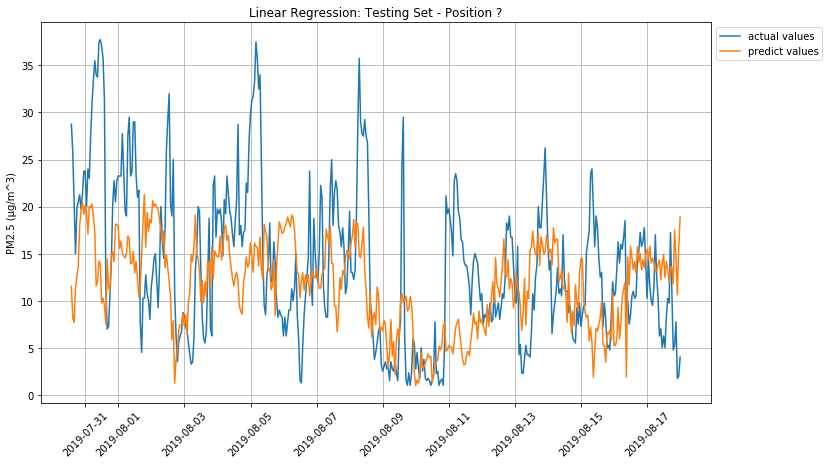

In [57]:
# Reset index
dfconcat.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)
# Shift columns
dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-1)
dfconcat[['time_shift']] = dfconcat[['time']].shift(-1)
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)
# Save mean and std
want_cols = ['pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'speed', 'pm2.5_shift']
mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all
# Divid training set and test set
four_fifth_len = len(dfconcat)*0.8
four_fifth_len = int(four_fifth_len)

train_df = dfconcat[:four_fifth_len]
test_df = dfconcat[four_fifth_len:]

# 'month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'speed'
X = train_df[['temp', 'humidity', 'speed']]
y = train_df[['pm2.5_shift']]

test_X = test_df[['temp', 'humidity', 'speed']]
test_y = test_df[['pm2.5_shift']]
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

m = mean_all['pm2.5']
s = std_all['pm2.5']

test_df_ori = test_df['pm2.5'] * s + m
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Testing Set - Position ?')
plt.grid()
plt.show()

### Add rainfall

In [58]:
station = str(467410)

def crawler_rain(month, date):
    # create url
    
    mon = ''
    if month < 10:
        mon = '0' + str(month)
    else:
        mon = str(month)
    
    day = ''
    if date < 10:
        day = '0' + str(date)
    else:
        day = str(date)
    datepicker = '2019-' + mon + '-' + day
    
    # url: https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=467410&stname=&datepicker=2019-08-07
    url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=' + station + '&stname=&datepicker=' + datepicker
    # print(url)
    
    # request
    response = requests.get(url)
    # print(response.text)
    
    # html parsing
    soup = BeautifulSoup(response.text, features="html.parser")
    
#    title = ['WS', 'WD']
    
    # get the daily data
    body = soup.tbody
    trs = body.find_all('tr')
    trs = trs[3:]
    
    winddata = []
    hour = 0
    # extract wind speed and wind direction
    for tds in trs:
        sd = {}
        td = tds.find_all('td')
#        print(td[0].string)
#        print(td[6].string)
#        print(td[7].string)
#        print('---')
#        if td[7].string == "V\xa0":
#            td[7].string = "0"
        sd['month'] = month
        sd['day'] = date
        sd['hour'] = hour
        
        tmp = td[10].string
        if tmp == 'T\xa0':
            sd['rain'] = 0.0
        else:
            sd['rain'] = float(tmp)
#        sd.append(int(td[7].string))
        winddata.append(sd)
        hour += 1
    
    # turn the list to dataframe
    #df = pd.DataFrame(data=winddata, columns=title)
    
    return winddata

In [59]:
rain_data = []
for month in [5, 6, 7, 8]:
    if month == 5:
        r = range(11, 32)
    elif month == 6:
        r = range(1, 31)
    elif month == 7:
        r = range(1, 32)
    elif month == 8:
        r = range(1, 18)
    for day in r:
        tmp = crawler_rain(month, day)
        rain_data = rain_data + tmp

In [60]:
rain = pd.DataFrame(rain_data)

In [61]:
rain.set_index(['month', 'day', 'hour'], inplace=True)

In [62]:
dfconcat = pd.concat([df3mean, wind, rain], axis=1, sort=False)

Coefficient for       temp:	-0.6299159071219355
Coefficient for   humidity:	-0.6842233725230275
Coefficient for      speed:	-0.21323638727918817
Coefficient for       rain:	-0.011954186166529787
Intercept: 			 -0.029665786052475815
Train MSE:	 107.379612,	 RMSE: 10.362413 (μg/m^3),	 MAPE:	 101.237297 %
Test MSE:	 66.558941,	 RMSE: 8.158366 (μg/m^3),	 MAPE:	 68.725743 %


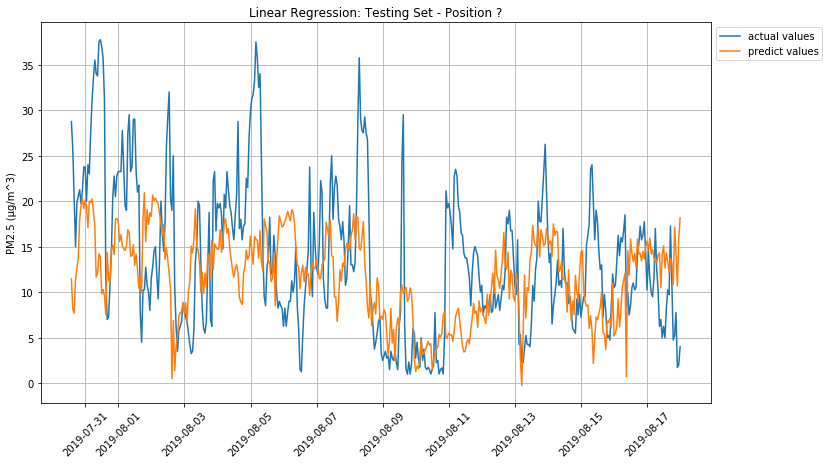

In [63]:
dfconcat.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

dfconcat['time'] = dfconcat[['month', 'day', 'hour']].apply(get_time, axis=1)
# Shift columns
dfconcat[['pm2.5_shift']] = dfconcat[['pm2.5']].shift(-1)
dfconcat[['time_shift']] = dfconcat[['time']].shift(-1)
# Discard rows that contain NaN value
dfconcat.dropna(inplace=True)
# Save mean and std
want_cols = ['pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'speed', 'pm2.5_shift']
mean_all = dfconcat.loc[:, want_cols].mean()
std_all = dfconcat.loc[:, want_cols].std()
# Normalization
dfconcat.loc[:, want_cols] = (dfconcat.loc[:, want_cols] - mean_all) / std_all
# Divid training set and test set
four_fifth_len = len(dfconcat)*0.8
four_fifth_len = int(four_fifth_len)

train_df = dfconcat[:four_fifth_len]
test_df = dfconcat[four_fifth_len:]

# 'month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity', 'speed'
X = train_df[['temp', 'humidity', 'speed', 'rain']]
y = train_df[['pm2.5_shift']]

test_X = test_df[['temp', 'humidity', 'speed', 'rain']]
test_y = test_df[['pm2.5_shift']]
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))
print('Intercept: \t\t\t %s' % model.intercept_[0])
# Calculate predict value
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)
# Transform normalized data back to original data
m = mean_all['pm2.5_shift']
s = std_all['pm2.5_shift']

test_y_ori = test_y * s + m
predict_y_ori = predict_y * s + m

y_ori = y * s + m
predict_train_y_ori = predict_train_y * s + m

m = mean_all['pm2.5']
s = std_all['pm2.5']

test_df_ori = test_df['pm2.5'] * s + m
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mse = metrics.mean_squared_error(y_ori, predict_train_y_ori)
test_mse = metrics.mean_squared_error(test_y_ori, predict_y_ori)

train_mape = mean_absolute_percentage_error(y_ori, predict_train_y_ori)
test_mape = mean_absolute_percentage_error(test_y_ori, predict_y_ori)

print('Train MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (train_mse, np.sqrt(train_mse), train_mape))
print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
# plt.plot(test_df['time'], test_df_ori, label='actual values')
plt.plot(test_df['time_shift'], test_y_ori, label='actual values')
plt.plot(test_df['time_shift'], predict_y_ori, label='predict values')
plt.xticks(rotation=45)
plt.ylabel('Time')
plt.ylabel('PM2.5 (μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Linear Regression: Testing Set - Position ?')
plt.grid()
plt.show()

## 時間序列分析: Prophet

In [4]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [5]:
# Load data
pos = 3
data3 = get_data_by_pos(pos)
df3 = pd.DataFrame(data3)
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
# df3 = df3.loc[ df3['date'] >= start_time ]
# df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Exclude outliers
df3 = df3.loc[ df3['pm2.5'] < 120 ]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()
df3mean.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)

In [6]:
# Create another df for fitting model
df_4_fit = pd.DataFrame(columns=['ds_tz','y'])
df_4_fit['ds_tz'] = df3mean['time']
df_4_fit['y'] = df3mean['pm2.5'].values

In [7]:
# Divid training set and test set
four_fifth_len = len(df3mean)*0.8
four_fifth_len = int(four_fifth_len)

train_prophet = df_4_fit[:four_fifth_len]
test_prophet = df_4_fit[four_fifth_len:]

In [8]:
# Discard timezone info
train_prophet['ds'] = train_prophet['ds_tz'].values
test_prophet['ds'] = test_prophet['ds_tz'].values

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Fit the model
prophet = Prophet(yearly_seasonality=False)
prophet.fit(train_prophet)

In [10]:
# 未來要預測的頻率（天、週….）與長度需要先用make_future_dataframe定義好，再利用模型預測數值
future = prophet.make_future_dataframe(freq = 'H', periods=len(test_prophet))

In [11]:
# Predict
forecast = prophet.predict(future)

In [12]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2317,2019-08-21 13:54:00,17.434529,4.589028,29.632936
2318,2019-08-21 14:54:00,17.856602,5.108468,29.748704
2319,2019-08-21 15:54:00,18.285064,5.853720,29.801557
2320,2019-08-21 16:54:00,18.791312,5.896371,30.712577
2321,2019-08-21 17:54:00,19.302545,6.700631,30.761717


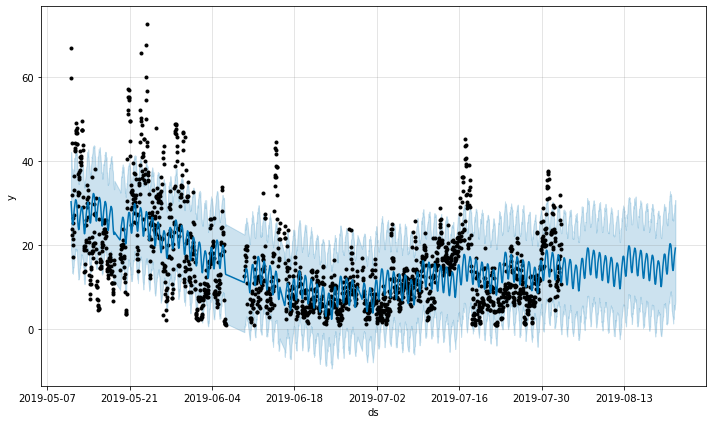

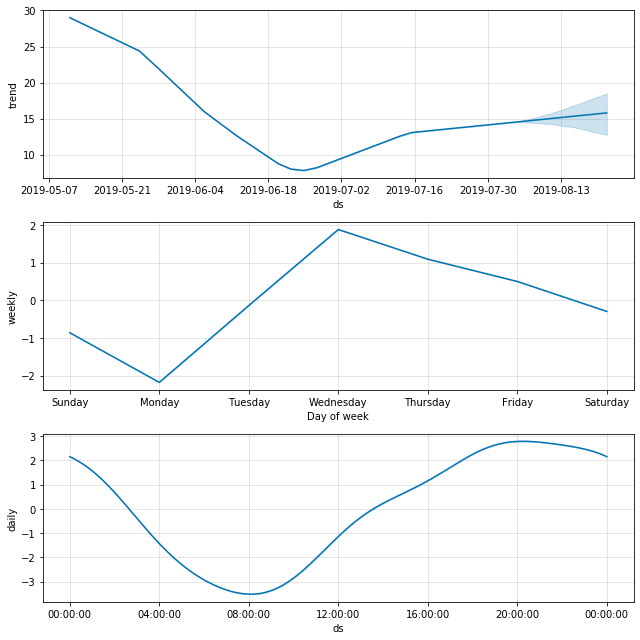

In [13]:
# 內建繪圖
prophet.plot(forecast)
prophet.plot_components(forecast);

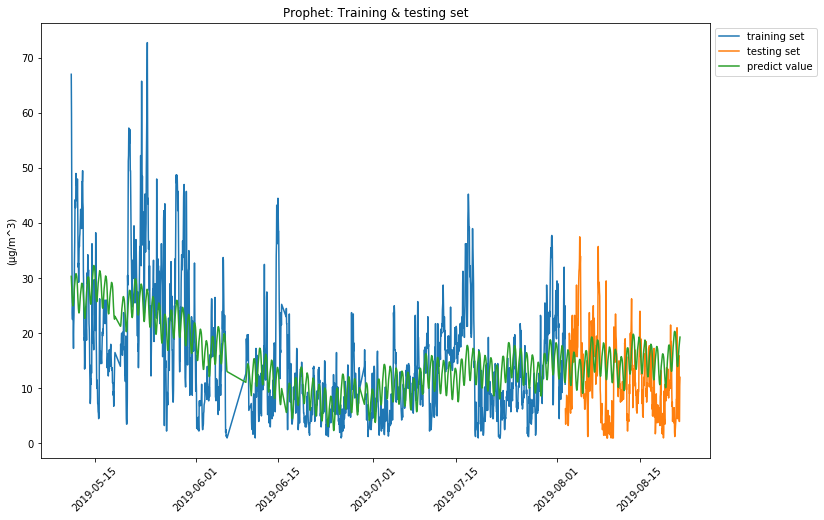

In [14]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 8))
# plt.style.use('ggplot')
plt.plot(train_prophet['ds'], train_prophet['y'], label='training set')
plt.plot(test_prophet['ds'], test_prophet['y'], label='testing set')
plt.plot(forecast['ds'], forecast['yhat'], label='predict value')
plt.xticks(rotation=45)
plt.ylabel('(μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Prophet: Training & testing set')
plt.show()

In [15]:
predict_y = forecast[['ds', 'yhat']]

In [16]:
# Add timezone
test_prophet['ds'] = test_prophet['ds'].apply(lambda x: x.tz_localize('UTC'))
test_prophet['ds'] = test_prophet['ds'].apply(lambda x: x.astimezone(pytz.timezone('Asia/Taipei')))
predict_y['ds'] = predict_y['ds'].apply(lambda x: x.tz_localize('UTC'))
predict_y['ds'] = predict_y['ds'].apply(lambda x: x.astimezone(pytz.timezone('Asia/Taipei')))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [17]:
# Select the testing set part
predict_y = predict_y[four_fifth_len:]

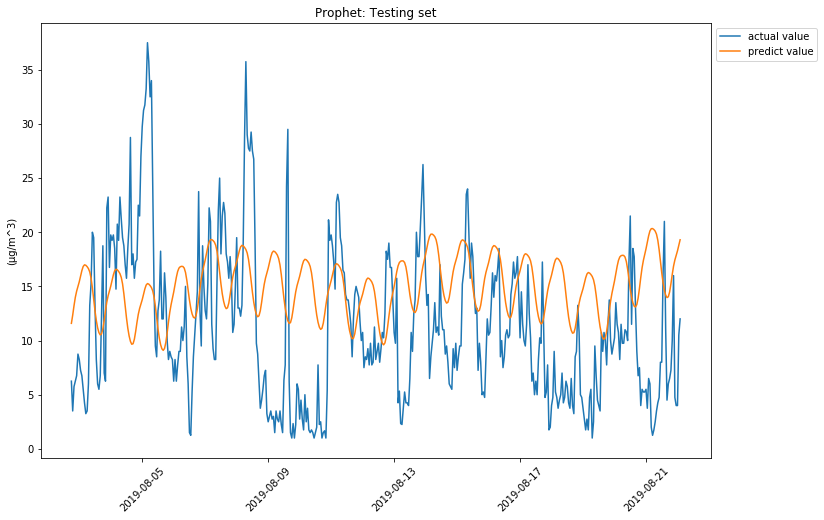

In [18]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 8))
plt.plot(test_prophet['ds'], test_prophet['y'], label='actual value')
plt.plot(predict_y['ds'], predict_y['yhat'], label='predict value')
plt.xticks(rotation=45)
plt.ylabel('(μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Prophet: Testing set')
plt.show()

In [19]:
# Calculate mean squared error for test set
test_mse = metrics.mean_squared_error(test_prophet['y'], predict_y['yhat'])
print('Test MSE:\t %s,\t RMSE: %s (μg/m^3)' % (test_mse, np.sqrt(test_mse)))

Test MSE:	 72.64106354869742,	 RMSE: 8.522972694353621 (μg/m^3)


In [20]:
# Calculate mean absolute percentage error for test set
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mean_absolute_percentage_error(test_prophet['y'], predict_y['yhat'])
print('Test MAPE:\t %s %%' % test_mape)

Test MAPE:	 152.67166316863455 %


## 時間序列分析: Holt-Winters' Method

In [64]:
from statsmodels.tsa.api import ExponentialSmoothing

In [65]:
# Load data
pos = 3
data3 = get_data_by_pos(pos)
df3 = pd.DataFrame(data3)
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
# df3 = df3.loc[ df3['date'] >= start_time ]
# df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Exclude outliers
df3 = df3.loc[ df3['pm2.5'] < 120 ]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()
df3mean.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)

In [66]:
# Divid training set and test set
four_fifth_len = len(df3mean)*0.8
four_fifth_len = int(four_fifth_len)
train_df = df3mean[:four_fifth_len]
test_df = df3mean[four_fifth_len:]

In [67]:
# Fit the model
Holt_Winters_model = ExponentialSmoothing(np.asarray(train_df['pm2.5']), 
                                          seasonal_periods=24, 
                                          trend='add', 
                                          seasonal='add', 
                                          damped=True).fit()
# Predict
predict_y = Holt_Winters_model.forecast(len(test_df))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


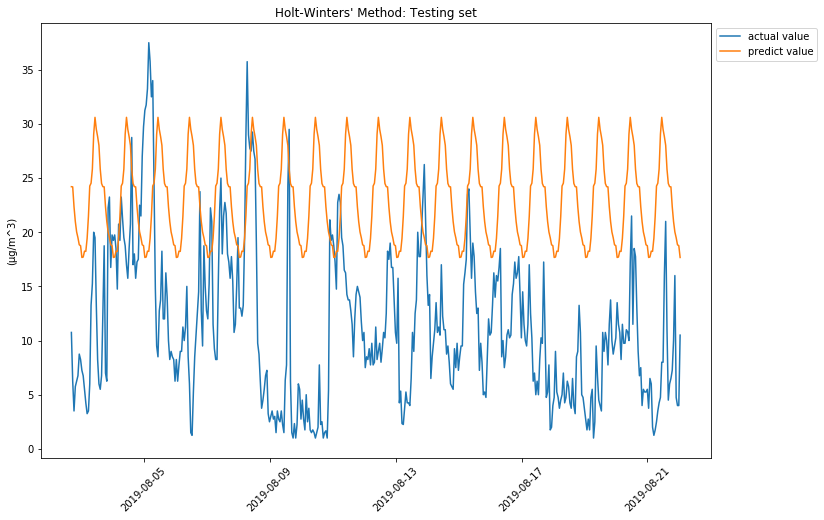

In [68]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 8))
# plt.style.use('ggplot')
plt.plot(test_df['time'], test_df['pm2.5'], label='actual value')
plt.plot(test_df['time'], predict_y, label='predict value')
plt.xticks(rotation=45)
plt.ylabel('(μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Holt-Winters\' Method: Testing set')
plt.show()

In [69]:
# Calculate mean squared error for test set
test_mse = metrics.mean_squared_error(test_df['pm2.5'], predict_y)
print('Test MSE:\t %s,\t RMSE: %s (μg/m^3)' % (test_mse, np.sqrt(test_mse)))

Test MSE:	 202.81096909113595,	 RMSE: 14.24117161932739 (μg/m^3)


In [70]:
# Calculate mean absolute percentage error for test set
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mean_absolute_percentage_error(test_df['pm2.5'], predict_y)
print('Test MAPE:\t %s %%' % test_mape)

Test MAPE:	 263.81340413606813 %


## ARIMA

In [4]:
import statsmodels.api as sm
# Augmented Dickey-Fuller (ADF) test 
from statsmodels.tsa.stattools import adfuller
# Decompose trend, seasonality & residual
from statsmodels.tsa.seasonal import seasonal_decompose
# ACF and PACF
from statsmodels.tsa.stattools import acf, pacf
# ARIMA 
from statsmodels.tsa.arima_model import ARIMA

In [5]:
# Load data
#pos = 3
data3 = get_data_by_pos(3)
df3 = pd.DataFrame(data3)
# Input time
#if pos == 2:
#    time = ['2019 06 06', '2020 01 01']
#else:
#    time = ['2019 05 11', '2020 01 01']
time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Exclude outliers
df3 = df3.loc[ df3['pm2.5'] < 120 ]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()
df3mean.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)

In [6]:
# Divid training set and test set
four_fifth_len = len(df3mean)*0.8
four_fifth_len = int(four_fifth_len)
train_df = df3mean[:four_fifth_len]
test_df = df3mean[four_fifth_len:]

In [7]:
df3mean['time_values'] = df3mean['time'].values

In [8]:
ts = df3mean[['time_values', 'pm2.5']].set_index('time_values')

In [9]:
# Define a function to test if our data is stationary
# Use a method called Augmented Dickey-Fuller (ADF) test 

def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()

    # Add explicitly converter
    pd.plotting.register_matplotlib_converters()
    # Plot rolling statistics:
    plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, label='Original')
    mean = plt.plot(rolmean, label='Rolling Mean')
    std = plt.plot(rolstd, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

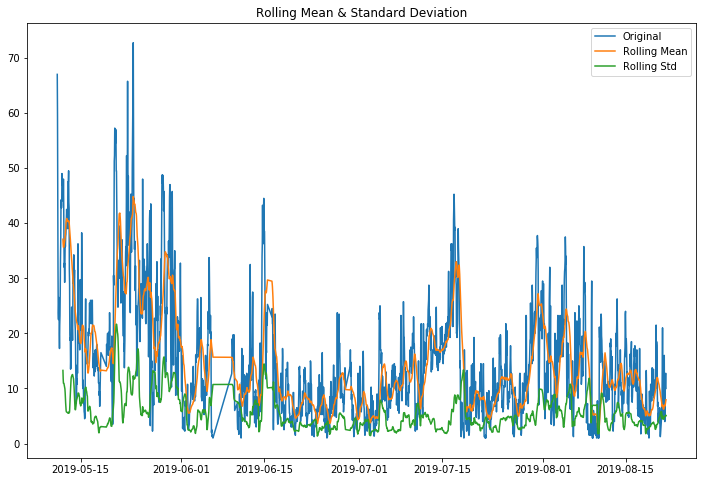

Results of Dickey-Fuller Test:
Test Statistic                   -4.596339
p-value                           0.000131
#Lags Used                       20.000000
Number of Observations Used    2303.000000
Critical Value (1%)              -3.433193
Critical Value (5%)              -2.862796
Critical Value (10%)             -2.567439
dtype: float64


In [10]:
test_stationarity(ts)

#### Try to Eliminate Trend & Seasonality

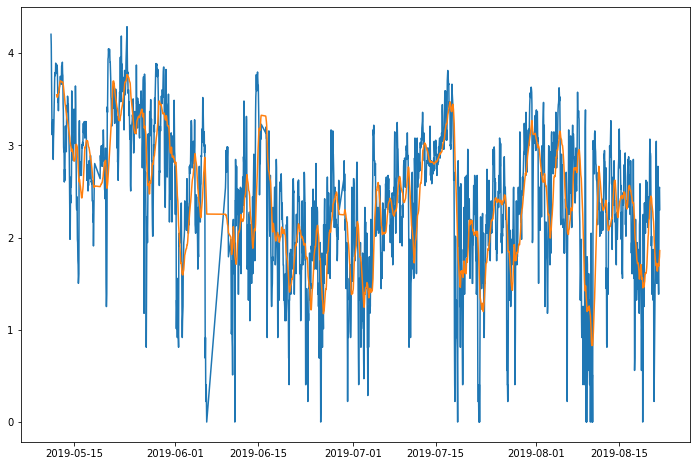

In [11]:
# Calculate log(ts) & its moving average
ts_log = np.log(ts)
moving_avg = ts_log.rolling(24).mean()

plt.figure(figsize=(12, 8))
plt.plot(ts_log)
plt.plot(moving_avg)

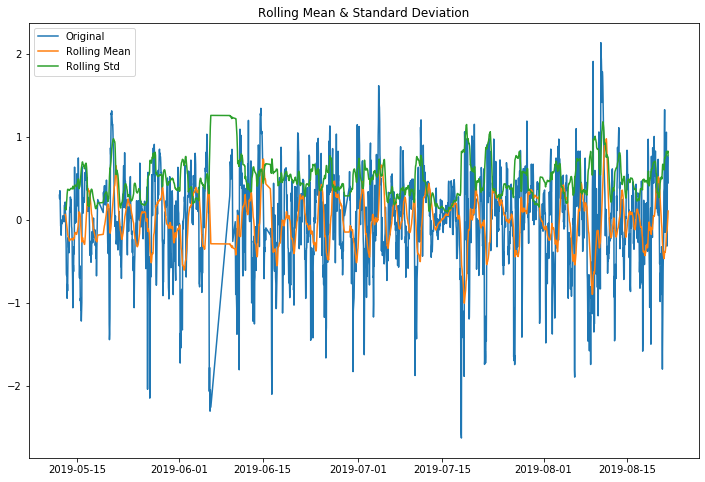

Results of Dickey-Fuller Test:
Test Statistic                -1.376931e+01
p-value                        9.750062e-26
#Lags Used                     1.100000e+01
Number of Observations Used    2.289000e+03
Critical Value (1%)           -3.433210e+00
Critical Value (5%)           -2.862804e+00
Critical Value (10%)          -2.567443e+00
dtype: float64


In [12]:
# Calculate log(ts) subtract the moving avg of log(ts)
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

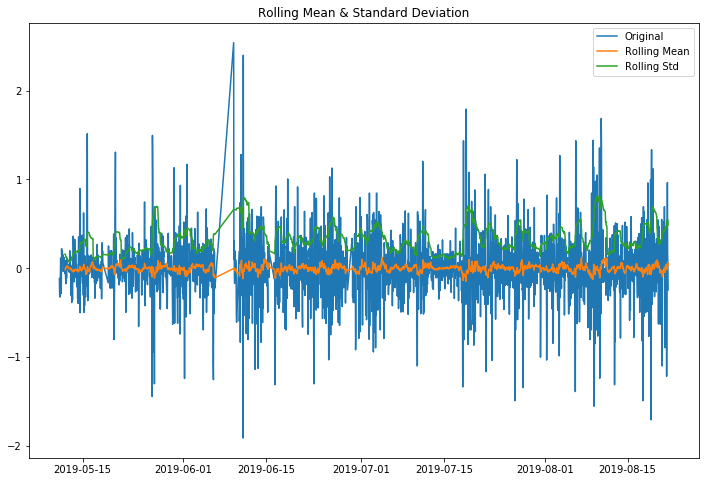

Results of Dickey-Fuller Test:
Test Statistic                -1.622871e+01
p-value                        3.831220e-29
#Lags Used                     2.000000e+01
Number of Observations Used    2.302000e+03
Critical Value (1%)           -3.433194e+00
Critical Value (5%)           -2.862796e+00
Critical Value (10%)          -2.567439e+00
dtype: float64


In [13]:
# Calculate the first-order difference
ts_log_diff = ts_log - ts_log.shift()

ts_log_diff.dropna(inplace=True)

test_stationarity(ts_log_diff)

In [ ]:
# Decompose trend, seasonality & residual
decomposition = seasonal_decompose(ts_log_diff)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Check the stability of residual
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

* 在AR(p)模型中，ACF為指數遞減，PACF為在p期截斷。
* 在MA(q)模型中，PACF為為指數遞減，ACF為q期截斷。

In [91]:
# ACF and PACF plots
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


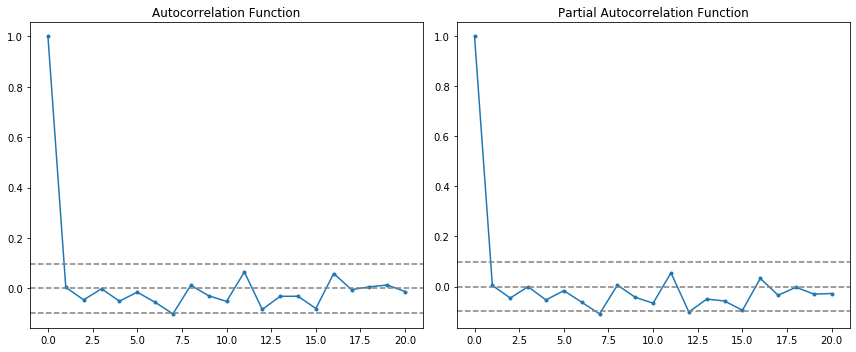

In [92]:
plt.figure(figsize=(12, 5))
# Plot ACF
plt.subplot(121) 
plt.plot(lag_acf, marker='.')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf, marker='.')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

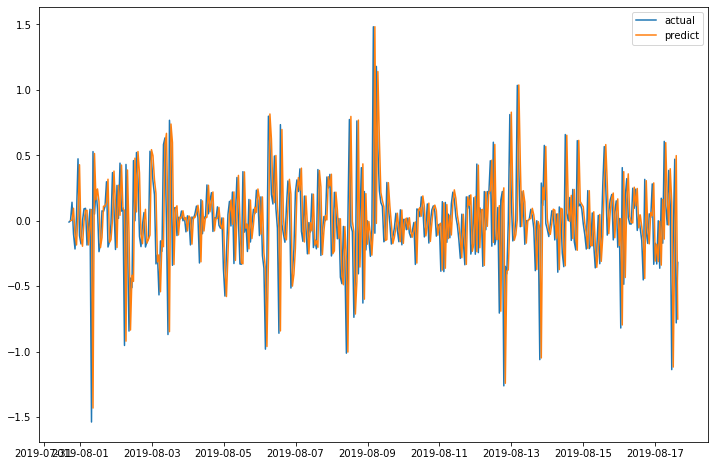

In [93]:
# Fit the model
model = ARIMA(ts_log_diff, order=(2, 1, 2), freq='H')  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(12, 8))
plt.plot(ts_log_diff, label='actual')
plt.plot(-results_ARIMA.fittedvalues, label='predict')
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.legend()
plt.show()

In [ ]:
# Fit the model
arima_model = sm.tsa.statespace.SARIMAX(train_df['pm2.5'], 
                                        order=(2, 1, 2),
                                        seasonal_order=(0,1,1,7)).fit()

In [ ]:
# Predict
predict_y = arima_model.predict(start='2019-07-31 15:54:00', 
                                end='2019-08-09 14:54:00', 
                                dynamic=True)